In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#Training Data

train = pd.read_csv('../input/nlp-getting-started/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Testing Data

test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# **EDA**

In [4]:
#Missing Values in Training Set

train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
#Missing Values in Testing Set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [6]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [8]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

<Axes: xlabel='keyword'>

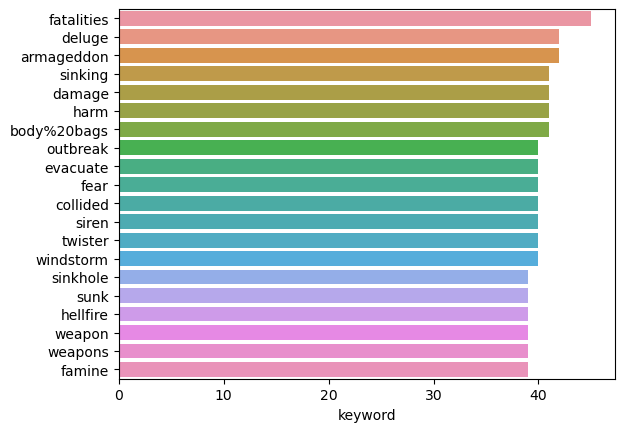

In [9]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

# **PreProcessing**

In [10]:
#Original Training Data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [12]:
# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [13]:
#Tokenization

text = train['text'][0]
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  our deeds are the reason of this earthquake may allah forgive us all
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Tokenization by words using Treebank Word Tokenizer:-  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Tokenization by punctuation:-  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Tokenization by regular expression:-  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']


In [14]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [15]:
#Removing Stop Words
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [16]:
# After preprocessing, the text format
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [17]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [18]:
# TFIDF
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# **Model**

In [19]:
# XGBoost
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
print('XGBoost', scores)

XGBoost [0.48498331 0.32860041 0.42528736 0.42182581 0.53256705]


In [20]:
# SVM
from sklearn.svm import SVC

svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
scores = model_selection.cross_val_score(svm, train_tfidf, train["target"], cv=5, scoring="f1")
print('SVM', scores)

SVM [0.55005269 0.46507177 0.52730697 0.45580405 0.64072398]


In [21]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
print('Naive Bayes:', scores)

Naive Bayes: [0.57590597 0.57092511 0.61135371 0.5962963  0.7393745 ]


In [22]:
target = train['target']
x, x_test, y, y_test = train_test_split(train_tfidf,target,test_size=0.2,train_size=0.8, random_state = 0)

clf = MultinomialNB(alpha=1).fit(x, y)

# **Submission**

In [23]:
preds = clf.predict(test_tfidf)
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target']= preds
submission.to_csv('submission.csv',index=False)